## Import necessary modules. 
Use 'ai4reg' for kernel. Note that the code was tested with Tensorflow 2.12. 
Some commands below do not work with newer versions of Tensorflow. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from numpy import std

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers

# Load the TensorBoard notebook extension
%load_ext tensorboard
import tensorflow as tf
from datetime import datetime

2024-11-13 15:39:24.385632: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Fix the random seed for producible results

In [2]:
# Seed value
seed = 1
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed)

# 5. Configure a new global `tensorflow` session
from tensorflow.compat.v1.keras.backend import set_session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

## Download data
The file below contains the hourly measurements of the interplanetary magnetic field (IMF), solar wind, and the ground magnetic field variation from 1995 to the end of 2019. The IMF and solar wind measurements were made by spacecraft upstream of the Earth. The ground magnetic field measurements were made at Chambon-la-Forêt observatory. The file has 14 columns including the timestamps: 

- **time**: time of the measurements in format yyyy-mm-dd HH:MM:SS
- **Bx_gse**: the x-component of the IMF in nanoTesla, where x points towards the Sun
- **By_gse**: the y-component of the IMF in nanoTesla, where y points duskward
- **By_gsm**: the z-component of the IMF in nanoTesla, where z points northward and aligns with the Earth's magnetic dipole
- **V**: the solar wind speed in km/s
- **N**: the solar wind proton number density in cm^-3
- **Temp**: the solar wind proton temperature in eV
- **F10.7**: the solar radio flux measurements. This parameter is measured once a day but then interpolated to hourly cadence.
- **local_time**: the local time of measurements in UT, from 0 to 23
- **DistSE**: the distance between Sun and Earth in astronomical units (A.U.), to be used as proxy for seasonal variation
- **xD**: the x-component (geographic north) of the ground magnetic field daily variation, in nanoTesla
- **yD**: the y-component (geographic east) of the ground magnetic field daily variation, in nanoTesla
- **zD**: the z-component (downward, towards the Earth core) of the ground magnetic field daily variation, in nanoTesla
 

In [3]:
# Download the file 
inputfile = 'solarw_geometry_magdaily_1995-2020_hourly.csv'

df = pd.read_csv(inputfile)
df['time'] = pd.to_datetime(df['time'])
df = df.set_index(['time']) # Make timestamp as index 
df

,Bx_gse,By_gsm,Bz_gsm,V,N,Temp,F10.7,local_time,SZA,DistSE,xD,yD,zD
time,,,,,,,,,,,,,
1995-01-01 00:00:00,-0.6,3.6,-1.2,315.0,16.3,15816.0,72.9,0.0,155.20,0.983325,-0.977299,4.004956,-0.684950
1995-01-01 01:00:00,-0.9,2.6,-0.7,315.0,18.8,15601.0,72.9,1.0,151.96,0.983324,-1.811840,1.059523,-0.683473
1995-01-01 02:00:00,0.5,1.8,0.0,320.0,19.3,20703.0,72.9,2.0,144.80,0.983324,0.263458,-1.224260,-0.733840
1995-01-01 03:00:00,-3.2,2.4,0.7,317.0,16.4,25094.0,72.9,3.0,135.70,0.983323,2.129897,-2.761787,-0.623952
1995-01-01 04:00:00,-4.3,2.1,0.5,313.0,14.5,25604.0,72.9,4.0,125.83,0.983323,2.542259,-3.643908,-0.321717
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-28 19:00:00,2.0,-1.1,-1.0,318.0,5.6,37794.0,69.8,19.0,118.15,0.983387,0.224158,1.435973,0.180608
2019-12-28 20:00:00,-2.6,-1.9,0.7,334.0,6.8,31737.0,69.8,20.0,128.20,0.983385,-0.327949,2.823559,0.030450
2019-12-28 21:00:00,-2.6,-2.1,-0.1,333.0,6.6,28100.0,69.8,21.0,137.97,0.983384,-0.394458,4.494567,0.140903


## Problem formulation: multivariate forecasting 

We want to forecast the Earth's magnetic field perturbations (**xD**, **yD**, **zD**) at the ground level as influenced by solar activities. Physically, **xD**, **yD**, and **zD** variations are triggered by various physical processes in the magnetosphere depending on the solar wind and IMF conditions, where the perturbations eventually reach the ground. In addition, **xD**, **yD**, and **zD** are strongly modulated by the daily and seasonal variations, thus parameters such as **local_time** and **DistSE** are relevant. 

This problem can be framed as "multivariate" forecasting, where several independent parameters will be used as input features to forecast several target variables simultaneously. It is a time-dependent problem.  We will use LSTM neural networks.  

The independent variables that influence the magnetic field measurements consist of the solar wind and interplanetary magnetic field measurements upstream of the Earth and the geometrical variables indicating the daily and seasonal variation. The target variables are **xD**, **yD**, and **zD**. 

## Defining train, validation, and test data to train a machine learning model
For sequential data, it is important to keep the order of the sequence. 

Here, we will specify 1 year of training data, 2 weeks of validation, and 2 weeks of test data. 

In [4]:
## Train interval 
t_train_begin = datetime(1995,1,1,0,0,0) 
t_train_end = datetime(1995,12,31,23,0,0) 
print("Train interval: ", t_train_begin, t_train_end)

## Validation interval
t_val_begin = datetime(1996,1,1,0,0,0) 
t_val_end = datetime(1996,1,14,23,0,0) 
print("Validation interval: ", t_val_begin, t_val_end)

# Test interval 
t_test_begin = datetime(1996,1,15,0,0,0) 
t_test_end = datetime(1996,1,30,23,0,0) 
print("Test interval: ", t_test_begin, t_test_end)

## Global interval - all the data will be inside this range
t1 = datetime(1995,1,1,0,0,0)
t2 = datetime(1996,2,1,0,0,0)

Train interval:  1995-01-01 00:00:00 1995-12-31 23:00:00
Validation interval:  1996-01-01 00:00:00 1996-01-14 23:00:00
Test interval:  1996-01-15 00:00:00 1996-01-30 23:00:00


### Limit the data to the global interval of interest

In [5]:
df = df[t1:t2]
df

,Bx_gse,By_gsm,Bz_gsm,V,N,Temp,F10.7,local_time,SZA,DistSE,xD,yD,zD
time,,,,,,,,,,,,,
1995-01-01 00:00:00,-0.6,3.6,-1.2,315.0,16.3,15816.0,72.9,0.0,155.20,0.983325,-0.977299,4.004956,-0.684950
1995-01-01 01:00:00,-0.9,2.6,-0.7,315.0,18.8,15601.0,72.9,1.0,151.96,0.983324,-1.811840,1.059523,-0.683473
1995-01-01 02:00:00,0.5,1.8,0.0,320.0,19.3,20703.0,72.9,2.0,144.80,0.983324,0.263458,-1.224260,-0.733840
1995-01-01 03:00:00,-3.2,2.4,0.7,317.0,16.4,25094.0,72.9,3.0,135.70,0.983323,2.129897,-2.761787,-0.623952
1995-01-01 04:00:00,-4.3,2.1,0.5,313.0,14.5,25604.0,72.9,4.0,125.83,0.983323,2.542259,-3.643908,-0.321717
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996-01-31 20:00:00,-4.4,-1.2,-0.7,515.0,4.3,131782.0,74.5,20.0,122.10,0.985182,7.555895,6.232132,1.946035
1996-01-31 21:00:00,-2.8,-1.6,-0.7,511.0,4.7,119158.0,74.5,21.0,131.75,0.985188,5.219466,6.701633,1.341117
1996-01-31 22:00:00,-2.5,-1.5,-1.9,502.0,4.1,108667.0,74.5,22.0,140.36,0.985194,-1.536945,8.184034,1.778828


## Define input features and output targets 

In [6]:
input_features = ['Bx_gse','By_gsm','Bz_gsm','V','N','Temp','F10.7','local_time','SZA','DistSE']
output_targets = ['xD','yD','zD']

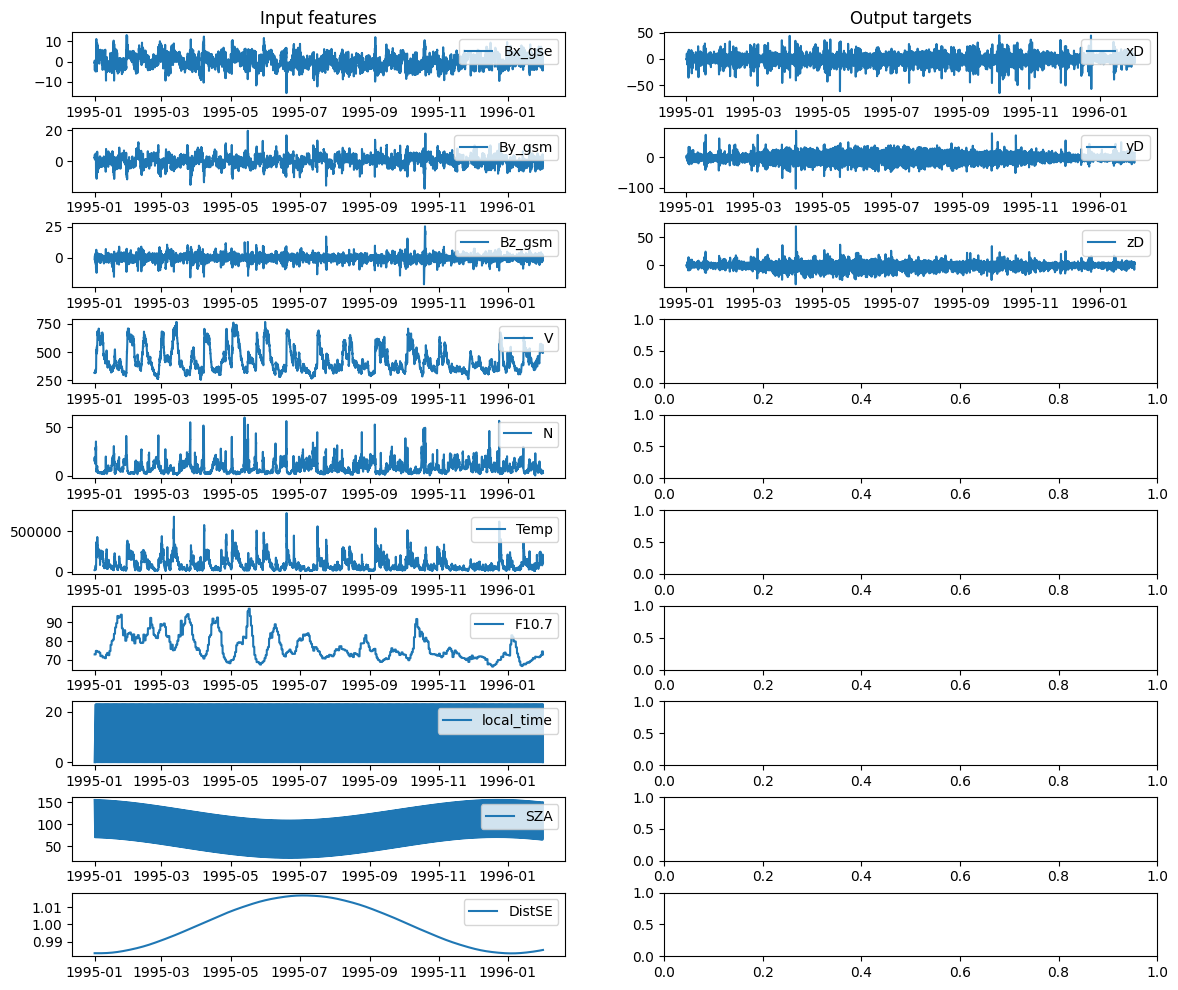

In [7]:
fig, ax = plt.subplots(len(input_features), 2, figsize=(14,12))
plt.subplots_adjust(hspace=0.5)

i = 0
for col in input_features:
    if i < len(input_features):
        ax[i,0].plot(df[col], label=col)
        ax[i,0].legend(loc='upper right',bbox_to_anchor=(1.0, 1.0))
        i += 1 
    
j = 0
for col in output_targets:
    if j < len(output_targets):
        ax[j,1].plot(df[col], label=col)
        ax[j,1].legend(loc='upper right',bbox_to_anchor=(1.0, 1.0))
        j += 1
    

ax[0,0].set_title('Input features')

ax[0,1].set_title('Output targets')

plt.show()

### Fix the order of the columns

In [8]:
df0 = df #save the original dataframe

new_column_order = ['Bx_gse','By_gsm','Bz_gsm','V','N','Temp','F10.7','local_time','SZA','DistSE','xD','yD','zD']
df = df[new_column_order]
df

,Bx_gse,By_gsm,Bz_gsm,V,N,Temp,F10.7,local_time,SZA,DistSE,xD,yD,zD
time,,,,,,,,,,,,,
1995-01-01 00:00:00,-0.6,3.6,-1.2,315.0,16.3,15816.0,72.9,0.0,155.20,0.983325,-0.977299,4.004956,-0.684950
1995-01-01 01:00:00,-0.9,2.6,-0.7,315.0,18.8,15601.0,72.9,1.0,151.96,0.983324,-1.811840,1.059523,-0.683473
1995-01-01 02:00:00,0.5,1.8,0.0,320.0,19.3,20703.0,72.9,2.0,144.80,0.983324,0.263458,-1.224260,-0.733840
1995-01-01 03:00:00,-3.2,2.4,0.7,317.0,16.4,25094.0,72.9,3.0,135.70,0.983323,2.129897,-2.761787,-0.623952
1995-01-01 04:00:00,-4.3,2.1,0.5,313.0,14.5,25604.0,72.9,4.0,125.83,0.983323,2.542259,-3.643908,-0.321717
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996-01-31 20:00:00,-4.4,-1.2,-0.7,515.0,4.3,131782.0,74.5,20.0,122.10,0.985182,7.555895,6.232132,1.946035
1996-01-31 21:00:00,-2.8,-1.6,-0.7,511.0,4.7,119158.0,74.5,21.0,131.75,0.985188,5.219466,6.701633,1.341117
1996-01-31 22:00:00,-2.5,-1.5,-1.9,502.0,4.1,108667.0,74.5,22.0,140.36,0.985194,-1.536945,8.184034,1.778828


## Divide the data before scaling

In [9]:
df_train = df[t_train_begin:t_train_end]
df_val = df[t_val_begin:t_val_end]
df_test = df[t_test_begin:t_test_end]

## Scale the train data 

In [10]:
## Scale the data frame
scaler = MinMaxScaler()

## Obtain scaler based on the "train" data
df_train_scaled = scaler.fit_transform(df_train)

## Convert from dataframe to 2D array
print('Train data: \n',df_train_scaled)
print(df_train_scaled.shape)

Train data: 
 [[0.52264808 0.57255937 0.43225806 ... 0.58303567 0.56151895 0.32872587]
 [0.51219512 0.54617414 0.44301075 ... 0.57549107 0.54615784 0.32873987]
 [0.56097561 0.52506596 0.45806452 ... 0.59425263 0.53424738 0.32826229]
 ...
 [0.64808362 0.32453826 0.50537634 ... 0.56953666 0.57826797 0.36421996]
 [0.42160279 0.46437995 0.48602151 ... 0.58809598 0.56582984 0.35460704]
 [0.5261324  0.40633245 0.54408602 ... 0.59110852 0.56002467 0.34452844]]
(8760, 13)


### Save the scaler for use later

In [11]:
from pickle import dump

# save the scaler
dump(scaler, open('Scaler_magnetic-prediction.pkl', 'wb'))

## Apply the scaling obtained from the "train" data to "validation" and "test" data

In [12]:
df_val_scaled = scaler.transform(df_val)
df_test_scaled = scaler.transform(df_test)

print('Validation data: \n',df_val_scaled)
print(df_val_scaled.shape)

print('Test data: \n',df_test_scaled)
print(df_test_scaled.shape)

Validation data: 
 [[0.52961672 0.38258575 0.54623656 ... 0.57699653 0.56082679 0.3374611 ]
 [0.6271777  0.39577836 0.48172043 ... 0.56704537 0.55685387 0.3335433 ]
 [0.66550523 0.42216359 0.50322581 ... 0.57685404 0.54505621 0.33167274]
 ...
 [0.57142857 0.33773087 0.34193548 ... 0.46565408 0.67341732 0.46488165]
 [0.59930314 0.34828496 0.40860215 ... 0.58014909 0.7719991  0.44431525]
 [0.67247387 0.38522427 0.49247312 ... 0.63029948 0.77433672 0.40484469]]
(336, 13)
Test data: 
 [[0.56445993 0.3878628  0.43655914 ... 0.64163858 0.68865759 0.36199076]
 [0.46341463 0.34828496 0.38494624 ... 0.67760709 0.59006478 0.3193247 ]
 [0.6271777  0.48548813 0.48172043 ... 0.72868118 0.54326825 0.28058019]
 ...
 [0.64808362 0.42216359 0.43225806 ... 0.57009003 0.55626234 0.37847528]
 [0.66550523 0.46437995 0.4688172  ... 0.61967084 0.58298753 0.37510218]
 [0.65505226 0.45118734 0.44301075 ... 0.64475671 0.61617025 0.3649864 ]]
(384, 13)


## Define X (independent variables) and y (dependent variables) 

In [13]:
## Get input 'X'
X_train = df_train_scaled[:,0:len(input_features)]

print('X train = \n',X_train)
print(X_train.shape)

## Get output 'y'
y_train = df_train_scaled[:,len(input_features):len(input_features)+len(output_targets)]

print('y train = \n',y_train)
print(y_train.shape)

X train = 
 [[5.22648084e-01 5.72559367e-01 4.32258065e-01 ... 0.00000000e+00
  9.97558892e-01 2.01272345e-03]
 [5.12195122e-01 5.46174142e-01 4.43010753e-01 ... 4.34782609e-02
  9.72842671e-01 1.99687560e-03]
 [5.60975610e-01 5.25065963e-01 4.58064516e-01 ... 8.69565217e-02
  9.18222873e-01 1.98121102e-03]
 ...
 [6.48083624e-01 3.24538259e-01 5.05376344e-01 ... 9.13043478e-01
  8.63450507e-01 5.17524234e-05]
 [4.21602787e-01 4.64379947e-01 4.86021505e-01 ... 9.56521739e-01
  9.30809838e-01 2.57237094e-05]
 [5.26132404e-01 4.06332454e-01 5.44086022e-01 ... 1.00000000e+00
  9.80852557e-01 0.00000000e+00]]
(8760, 10)
y train = 
 [[0.58303567 0.56151895 0.32872587]
 [0.57549107 0.54615784 0.32873987]
 [0.59425263 0.53424738 0.32826229]
 ...
 [0.56953666 0.57826797 0.36421996]
 [0.58809598 0.56582984 0.35460704]
 [0.59110852 0.56002467 0.34452844]]
(8760, 3)


### Split X and Y for validation and test data

In [14]:
X_val = df_val_scaled[:,0:len(input_features)]
X_test = df_test_scaled[:,0:len(input_features)]

y_val = df_val_scaled[:,len(input_features):len(input_features)+len(output_targets)]
y_test = df_test_scaled[:,len(input_features):len(input_features)+len(output_targets)]

##  Transform X and y for Keras LSTM

In [15]:
def lstm_data_transform(x_data, y_data, num_steps=5):
    """ Changes data to the format for LSTM training
for sliding window approach """    # Prepare the list for the transformed data
    X, y = list(), list()    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)    
    return x_array, y_array

## Transform data with lookback: length of history to be taken into account

In [16]:
num_steps = 12 # 12 hours (1 hour cadence) 

X_train_seq, y_train_seq = lstm_data_transform(X_train, y_train, num_steps=num_steps)
X_val_seq, y_val_seq = lstm_data_transform(X_val, y_val, num_steps=num_steps)
X_test_seq, y_test_seq = lstm_data_transform(X_test, y_test, num_steps=num_steps)

print ("The new shape of X_train is", X_train_seq.shape)
print ("The new shape of y_train is", y_train_seq.shape)

print ("The new shape of X_val is", X_train_seq.shape)
print ("The new shape of y_val is", y_train_seq.shape)

print ("The new shape of X_test is", X_test_seq.shape)
print ("The new shape of y_test is", y_test_seq.shape)

The new shape of X_train is (8748, 12, 10)
The new shape of y_train is (8748, 3)
The new shape of X_val is (8748, 12, 10)
The new shape of y_val is (8748, 3)
The new shape of X_test is (372, 12, 10)
The new shape of y_test is (372, 3)


### Visualise the data partitioning for train:validation:test 

In [17]:
# Below is to find the corresponding indices of train, validation, and test boundaries 
df = df.reset_index()

train_ind_begin = df[df.time == t_train_begin].index.tolist()[0]
train_ind_end = df[df.time == t_train_end].index.tolist()[0]
num_train_elements = train_ind_end - train_ind_begin
print('Beginning of the train index: ',train_ind_begin, df.time[train_ind_begin])
print('End of the train index: ',train_ind_end, df.time[train_ind_end])
print('Total number of elements: ', num_train_elements)

## Validation set 
val_ind_begin = df[df.time == t_val_begin].index.tolist()[0]
val_ind_end = df[df.time == t_val_end].index.tolist()[0]
num_val_elements = val_ind_end - val_ind_begin
print('\nBeginning of the validation index: ', val_ind_begin, df.time[val_ind_begin])
print('End of the validation index: ', val_ind_end, df.time[val_ind_end])
print('Total number of elements: ', num_val_elements)

## First test set 
test_ind_begin = df[df.time == t_test_begin].index.tolist()[0]
test_ind_end = df[df.time == t_test_end].index.tolist()[0]
num_test_elements = test_ind_end - test_ind_begin
print('\nBeginning of the test index: ',test_ind_begin, df.time[test_ind_begin])
print('End of the test index: ',test_ind_end, df.time[test_ind_end])
print('Total number of elements: ', num_test_elements)

## Ratio of (train + valid) to (test + valid + train):  
print('\nRatio of (train + valid) to (test + valid + train): ', (num_train_elements + num_val_elements)/(num_train_elements + num_val_elements + num_test_elements))

Beginning of the train index:  0 1995-01-01 00:00:00
End of the train index:  8759 1995-12-31 23:00:00
Total number of elements:  8759

Beginning of the validation index:  8760 1996-01-01 00:00:00
End of the validation index:  9095 1996-01-14 23:00:00
Total number of elements:  335

Beginning of the test index:  9096 1996-01-15 00:00:00
End of the test index:  9479 1996-01-30 23:00:00
Total number of elements:  383

Ratio of (train + valid) to (test + valid + train):  0.9595863669937744


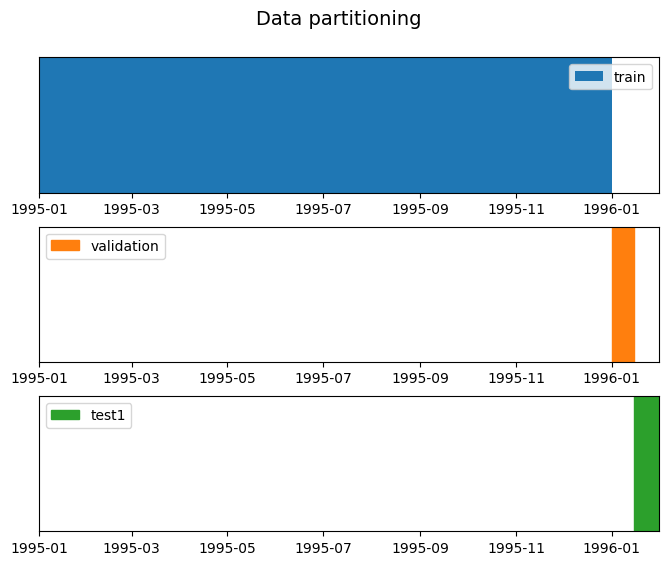

In [18]:
df = df.set_index('time')

fig, ax = plt.subplots(3, 1, figsize=(8, 6))
plt.subplots_adjust(hspace=0.25)

ax[0].axvspan(ymin=0, ymax=1, xmin=df.index[train_ind_begin], xmax=df.index[train_ind_end], label='train')
ax[1].axvspan(ymin=0, ymax=1, xmin=df.index[val_ind_begin], xmax=df.index[val_ind_end], label='validation', color='C1')
ax[2].axvspan(ymin=0, ymax=1, xmin=df.index[test_ind_begin], xmax=df.index[test_ind_end], label='test1', color='C2')

j=0
for j in range(3):
    ax[j].set_xlim(t_train_begin, t_test_end)
    ax[j].set_ylim(0,1)
    ax[j].legend(loc='best')
    ax[j].set_yticks([]) 
    
fig = plt.gcf()
fig.subplots_adjust(top=0.9)
fig.suptitle("Data partitioning", fontsize=14)

plt.show()

## Train the model with the training data

### Launch the Tensorboard to track the training

In [19]:
#%tensorboard --logdir logs/fit
%tensorboard --logdir=logs/fit/ --host localhost  --port=8008

Reusing TensorBoard on port 8008 (pid 43521), started 4:24:58 ago. (Use '!kill 43521' to kill it.)

## Model training with multiple-layer LSTM neural network

### Define the model 

In [20]:
%%time

model = Sequential()
model.add(LSTM(100, input_dim=len(input_features), 
               kernel_initializer='he_uniform', 
               return_sequences=True,
               activation='relu'))
model.add(LSTM(50, return_sequences=True, activation='relu'))
#model.add(LSTM(50, return_sequences=True, activation='relu'))
#model.add(LSTM(50, return_sequences=True, activation='relu'))
model.add(LSTM(50, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(len(output_targets)))
adam = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 100)         44400     
                                                                 
 lstm_1 (LSTM)               (None, None, 50)          30200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 94,953
Trainable params: 94,953
Non-trainable params: 0
_________________________________________________________________
CPU times: user 270 ms, sys: 17.1 ms, total: 287 ms
Wall time: 257 ms


## Setting up model path for logging the training progress

In [21]:
model_path = 'Multivariate_LSTM_magnetic-prediction_clean/'

log_dir = "logs/fit/{}".format(model_path) + datetime.now().strftime("%Y%m%d-%H%M%S")

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

### Set up Tensorboard callback to track model training progression 
### Set up checkpoint in order to save only best model
### Set up earlystopping to stop the model training after no improvement for 5 consecutive epochs 

In [22]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# checkpoint
filepath="Saved_models/{}".format(model_path)

if not os.path.exists(filepath):
    os.makedirs(filepath)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath + "model_weights.best.hdf5", monitor='val_loss', verbose=1, save_best_only=True)

earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

## Train and validate the model

In [23]:
%%time

model.fit(X_train_seq, y_train_seq, epochs=50, 
          validation_data=(X_val_seq, y_val_seq),
          batch_size=256,
          callbacks=[tensorboard_callback, earlystopping_callback, checkpoint])

Epoch 1/50
35/35 [==============================] - ETA: 0s - loss: 0.0608
Epoch 1: val_loss improved from inf to 0.00400, saving model to Saved_models/Multivariate_LSTM_magnetic-prediction_clean/model_weights.best.hdf5
35/35 [==============================] - 4s 54ms/step - loss: 0.0608 - val_loss: 0.0040
Epoch 2/50
33/35 [===========================>..] - ETA: 0s - loss: 0.0051
Epoch 2: val_loss improved from 0.00400 to 0.00282, saving model to Saved_models/Multivariate_LSTM_magnetic-prediction_clean/model_weights.best.hdf5
35/35 [==============================] - 1s 40ms/step - loss: 0.0051 - val_loss: 0.0028
Epoch 3/50
33/35 [===========================>..] - ETA: 0s - loss: 0.0042
Epoch 3: val_loss improved from 0.00282 to 0.00237, saving model to Saved_models/Multivariate_LSTM_magnetic-prediction_clean/model_weights.best.hdf5
35/35 [==============================] - 1s 40ms/step - loss: 0.0042 - val_loss: 0.0024
Epoch 4/50
33/35 [===========================>..] - ETA: 0s - loss: 

## Model prediction on test set

In [24]:
test_predict = model.predict(X_test_seq)
print(test_predict.shape)

12/12 [==============================] - 0s 5ms/step
(372, 3)


## Model evaluation on test set

### Loss, MSE, Pcc of the test set

In [25]:
print('Test 1', t_test_begin, t_test_end)

score_test = model.evaluate(X_test_seq, y_test_seq, verbose=0)
print('\nLoss score = ', score_test)

mse_test = []
for i in range(y_test_seq.shape[1]):
    mse_test.append(mean_squared_error(y_test_seq[:,i], test_predict[:,i]))
print('\nMSE of all targets = ', mse_test)

Pcc_xyz_test = []
for i in range(y_test_seq.shape[1]):
    Pcc_xyz_test.append(round(np.corrcoef(y_test_seq[:,i], test_predict[:,i])[0,1],3))
print('\nPcc of all targets = ', Pcc_xyz_test)

Test 1 1996-01-15 00:00:00 1996-01-30 23:00:00

Loss score =  0.0015207784017547965

MSE of all targets =  [0.0030622046240075754, 0.0010778456833152184, 0.00042228526694141645]

Pcc of all targets =  [0.61, 0.785, 0.829]


## Scale back the data

### Concatenate the scaled 'X' and the 'test predict' for using the inverse scaling later

In [26]:
predict_scaled = np.concatenate((X_test_seq[:,0,:],test_predict), axis=1)
print(predict_scaled.shape)
print(predict_scaled)

(372, 13)
[[0.56445993 0.3878628  0.43655914 ... 0.52565247 0.46906036 0.30030304]
 [0.46341463 0.34828496 0.38494624 ... 0.52350169 0.46405035 0.32424206]
 [0.6271777  0.48548813 0.48172043 ... 0.51997244 0.46478856 0.35092574]
 ...
 [0.79790941 0.45118734 0.48172043 ... 0.61902207 0.60589737 0.38554975]
 [0.79442509 0.44854881 0.48817204 ... 0.63430476 0.60866541 0.37307331]
 [0.77003484 0.41688654 0.47096774 ... 0.64086807 0.60395753 0.36193138]]


In [27]:
# Perform inverse scaling
predict = scaler.inverse_transform(predict_scaled)
print(predict)
print(predict.shape)

[[  0.6         -3.4         -1.         ...  -7.32470411 -13.72361318
   -3.68247878]
 [ -2.3         -4.9         -3.4        ...  -7.56261056 -14.68426253
   -1.15782192]
 [  2.4          0.3          1.1        ...  -7.9529963  -14.54271493
    1.65629389]
 ...
 [  7.3         -1.           1.1        ...   3.00331311  12.51434077
    5.30781217]
 [  7.2         -1.1          1.4        ...   4.69379786  13.04510142
    3.99202108]
 [  6.5         -2.3          0.6        ...   5.41979362  12.14238544
    2.81697099]]
(372, 13)


### Make a dataframe for the output 

In [28]:
df_predict = pd.DataFrame(predict)
df_predict.columns = new_column_order
df_predict['time'] = df.index[test_ind_begin+num_steps:test_ind_end+1]
df_predict = df_predict.set_index(['time'])
df_predict

,Bx_gse,By_gsm,Bz_gsm,V,N,Temp,F10.7,local_time,SZA,DistSE,xD,yD,zD
time,,,,,,,,,,,,,
1996-01-15 12:00:00,0.6,-3.4,-1.0,617.0,5.0,322526.0,67.9,0.0,153.460,0.983574,-7.324704,-13.723613,-3.682479
1996-01-15 13:00:00,-2.3,-4.9,-3.4,636.0,4.4,299125.0,67.9,1.0,150.840,0.983576,-7.562611,-14.684263,-1.157822
1996-01-15 14:00:00,2.4,0.3,1.1,610.0,4.6,335848.0,67.9,2.0,144.170,0.983579,-7.952996,-14.542715,1.656294
1996-01-15 15:00:00,2.0,-2.5,1.2,609.0,4.2,301724.0,67.9,3.0,135.340,0.983582,-8.727847,-11.066113,4.426596
1996-01-15 16:00:00,3.2,-3.3,1.9,611.0,4.2,239741.0,67.9,4.0,125.570,0.983584,-8.060524,-6.231533,6.264784
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996-01-30 19:00:00,6.1,-1.7,4.4,562.0,3.5,198466.0,72.5,7.0,94.167,0.984984,-3.018963,7.362225,7.631700
1996-01-30 20:00:00,7.2,-1.0,2.8,553.0,3.5,155555.0,72.5,8.0,85.254,0.984989,0.070821,10.711080,6.731481
1996-01-30 21:00:00,7.3,-1.0,1.1,552.0,3.2,146290.0,72.5,9.0,77.463,0.984994,3.003313,12.514341,5.307812


## Visualize rescaled prediction versus observation (final results)

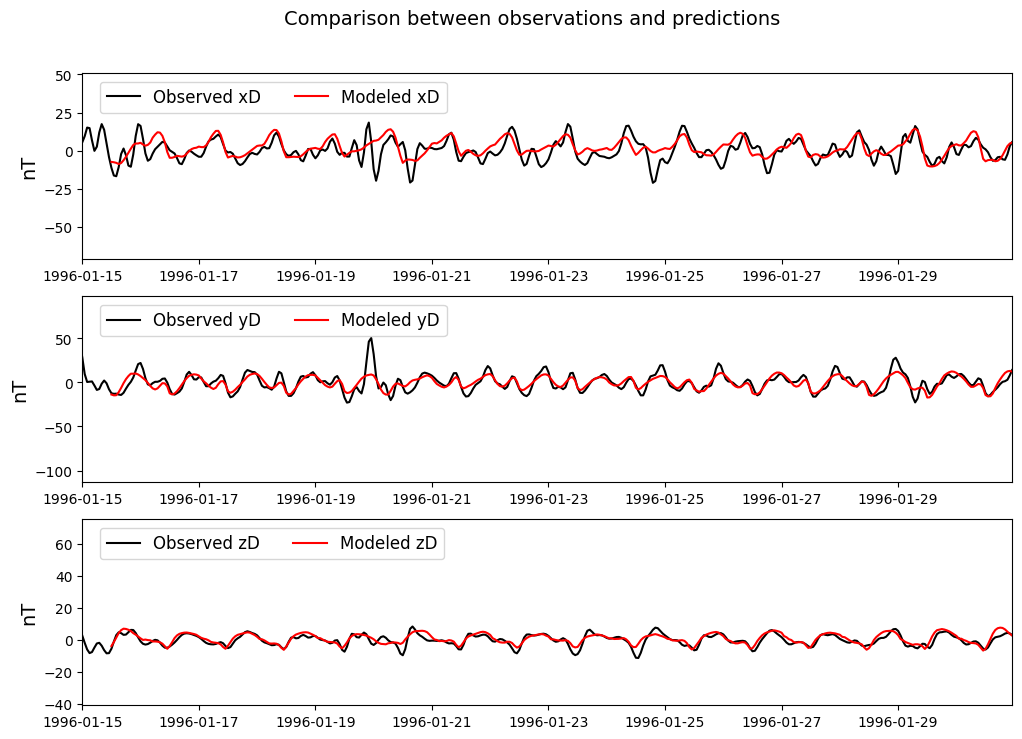

In [29]:
## test 1

output_targets = ['xD','yD','zD']

fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
plt.subplots_adjust(hspace=0.2)

j = 0
for col in output_targets:
    if j < len(output_targets):
        ax[j].plot(df0[col], label='Observed ' + col, color='k')
        ax[j].plot(df_predict[col], label='Modeled ' + col, color='r')
        ax[j].legend(loc='upper left',bbox_to_anchor=(.01, 1.0),ncols=2, fontsize=12)
        ax[j].set_xlim(t_test_begin, t_test_end)
        ax[j].set_ylabel('nT', fontsize=14)
        ax[j].xaxis.get_label().set_fontsize(16)
        j += 1
        
fig = plt.gcf()
fig.subplots_adjust(top=0.9)
fig.suptitle("Comparison between observations and predictions", fontsize=14)

plt.show()